# Imports

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
import myOptimizers as optims
import os
import importlib

# Function Definitions

In [2]:
# Weight initialisation
def init_random_params(scale, layer_sizes, rs=npr.RandomState(42)):
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

# Activation function
def tanh(x):
    return (2 / (1.0 + np.exp(-2*x))) - 1
    #return np.log(1+np.exp(x))
    #return np.exp(x)

# Returns the NN output AFTER enforcing the boundary condition. This is the wavefunction (wf).
def psi(nnparams, inputs):
    origInput = inputs
    xTilde = (origInput - x0) / (x1 - x0)
    
    for W, b in nnparams:
        outputs = np.dot(inputs, W) + b
        inputs = tanh(outputs)    
        
    # Enforcing the boundary conditions
    return (1-xTilde)*psi0 + xTilde*psi1 + (1-np.exp(xTilde * (1 - xTilde))) * outputs


dpsi = elementwise_grad(psi, 1) # Function for returning first derivative of wf (not used explicitly)
ddpsi = elementwise_grad(dpsi, 1) # Second derivative of wf. 

In [3]:
def floatStr (Efloat) :
    Eint = int(np.floor(Efloat))
    if Efloat - Eint == 0 :
        return str(int(np.floor(Efloat)))
    else :
        Estr = str(Efloat)
        return str(int(np.floor(Efloat))) + "p" + Estr[Estr.find('.')+1:]

# Objective function
def objective(params, step):
    nnparams = params['nn']
    E = params['E']        
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    
    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    

    return np.mean(diffeq**2) + (1-prob)**2

trunc = -1
iterList = []
diffeqList = []
diffeqDiffList = []
probList = []
lossList = []
EList = []
# Helper function for callback. Prints the following -
# 1. Iteration no.
# 2. MSE term
# 3. Probability integral
# 4. Loss
# 5. Eigen-energy 
def objectiveDebug (params, step) :
    nnparams = params['nn']
    E = params['E']   
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    mean = np.mean(diffeq**2)  # MSE

    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    
    loss = mean + (1-prob)**2
    
    iterList.append (step)
    diffeqList.append (mean)
    probList.append (prob)
    lossList.append (loss)
    EList.append (float(params['E']))

    print ("Iteration " + str(step) + "\ndiffeq = " + str(mean) + " prob = " + str(prob))
    print ("loss = " + str(loss) + " E = " + str(params['E']))

# Callback function.
def callback(params, step, g):
    global trunc
    global diffeqList
    
    if step % 100 == 0:
        objectiveDebug (params, step)
        
        if step > 100 :
            if trunc == -1 and np.abs(diffeqDiffList[-1]) < 10**-2 and diffeqDiffList[-1] < 0 :
                trunc = int(step/100)
                print ("Set at index = " + str(trunc))        

# Initialisation

In [4]:
psi0 = 0 # Value of first boundary
psi1 = 0 # Value of second boundary
L = 1 # Length of the well
n = 1 # Energy level to be found
scale = 2*L # Scale for initialisation
divs = 200 # divisions of the input space

x0 = 0  # Position of first boundary
x1 = L  # Position of second boundary

In [5]:
# Initialising the weights. They usually fall between 0 and 1 which causes the initial wavefunction
# to have a small probability integral over the range. Hence, I've put a scale factor of 2 that changes gives it
# a random (but sizeable) shape so that over the epochs, the probability integral converges to 1.
nnparams = init_random_params(scale/(x1-x0), layer_sizes=[1, 32, 32, 1])

# Intialise a guess eigenvalue to find a true eigenvalue near it
initE = 5.5
params = {'nn': nnparams, 'E': initE}

# Input space
x = np.linspace(x0, x1, divs)[:, None]

# Setting up the name for saving files
name = "n" + str(n)+ "L" + floatStr(L) + "E" + floatStr(float(params['E']))

# Optimization

In [6]:
optims = importlib.reload (optims)
params = optims.myAdam (grad(objective), params, callback=callback, step_size=0.001, diffeqList=diffeqList, probList=probList, diffeqDiffList = diffeqDiffList)

Iteration 100
diffeq = 28.80425232074886 prob = 1.9096090167783222
loss = 29.631640884153285 E = 5.522576152862585
---------------------------------
Iteration 200
diffeq = 4.968306484656197 prob = 1.393842656150958
loss = 5.123418522460239 E = 5.492724665054356
diffeqDiff = -23.835945836092662
---------------------------------
Iteration 300
diffeq = 2.2252937508624204 prob = 1.1814957334295206
loss = 2.25823445211554 E = 5.459429151217235
diffeqDiff = -2.7430127337937766
---------------------------------
Iteration 400
diffeq = 1.368491375749666 prob = 1.0566066748007406
loss = 1.3716956913816627 E = 5.427058736134676
diffeqDiff = -0.8568023751127545
---------------------------------
Iteration 500
diffeq = 0.9243700517657141 prob = 0.9938125981909397
loss = 0.9244083357068609 E = 5.395028346873048
diffeqDiff = -0.4441213239839519
---------------------------------
Iteration 600
diffeq = 0.6530612676217732 prob = 0.9557907261558485
loss = 0.6550157275156003 E = 5.363171814558306
diffeqDif

Iteration 4300
diffeq = 0.008079062927713567 prob = 0.999394973761686
loss = 0.008079428984462615 E = 4.93481894988118
diffeqDiff = -0.003705484748294262
brkCount2 = 14
---------------------------------
Iteration 4400
diffeq = 0.12143605483138518 prob = 1.001464833275615
loss = 0.12143820056791053 E = 4.934811260213641
diffeqDiff = 0.11335699190367161
---------------------------------
Iteration 4500
diffeq = 0.006990826529071118 prob = 0.999505369861298
loss = 0.00699107118804523 E = 4.934825741160896
diffeqDiff = -0.11444522830231407
---------------------------------
Iteration 4600
diffeq = 0.006482781217564587 prob = 0.9994992383901542
loss = 0.006483031979754483 E = 4.934812602890849
diffeqDiff = -0.000508045311506531
brkCount3 = 11
---------------------------------
Iteration 4700
diffeq = 0.006595571584154545 prob = 0.9993752493708972
loss = 0.006595961897503109 E = 4.934846196462377
diffeqDiff = 0.00011279036658995781
---------------------------------
Iteration 4800
diffeq = 0.005

Iteration 8400
diffeq = 0.0016157278724050024 prob = 0.9997235430385887
loss = 0.0016158043008565152 E = 4.934804672474914
diffeqDiff = 0.00018760928773516104
---------------------------------
Iteration 8500
diffeq = 0.0013636840792070198 prob = 1.0000030352670548
loss = 0.001363684088419866 E = 4.934802696489458
diffeqDiff = -0.00025204379319798253
brkCount3 = 27
---------------------------------
Iteration 8600
diffeq = 0.0025498557296141965 prob = 0.9997671096926909
loss = 0.002549909967509435 E = 4.934842173343419
diffeqDiff = 0.0011861716504071767
---------------------------------
Iteration 8700
diffeq = 0.0013043511169821187 prob = 1.0000038944639895
loss = 0.0013043511321489685 E = 4.934802884753318
diffeqDiff = -0.0012455046126320778
brkCount2 = 18
---------------------------------
Iteration 8800
diffeq = 0.010082558053623576 prob = 0.99751399595933
loss = 0.010088738269713803 E = 4.935150499137248
diffeqDiff = 0.008778206936641457
---------------------------------
Iteration 890

Iteration 11700
diffeq = 0.0008084320424651146 prob = 0.9998844833021092
loss = 0.0008084453865726063 E = 4.934803301735939
diffeqDiff = -0.0004164436827108355
brkCount3 = 33
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 12000
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 11800
diffeq = 0.02361591212102379 prob = 1.0009440058570807
loss = 0.023616803268081993 E = 4.934870725608621
diffeqDiff = 0.022807480078558675
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 12000
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 11900
diffeq = 0.00922646713146918 prob = 1.0026942004259771
loss = 0.009233725847404515 E = 4.93484412219044
diffeqDiff = -0.014389444989554611
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 12000
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 12000
diffeq = 0.0027327059981583756 prob = 1.001197583796194
loss = 0.00273414020510

Iteration 14400
diffeq = 0.003821397992757827 prob = 1.00188097388442
loss = 0.003824936055511698 E = 4.934809350256498
diffeqDiff = -0.05040084672654734
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 12000
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 14500
diffeq = 0.0005199633315680987 prob = 0.9999980150404125
loss = 0.0005199633355081633 E = 4.93480086263389
diffeqDiff = -0.0033014346611897286
brkCount2 = 31
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 12000
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 14600
diffeq = 0.0009108973303591992 prob = 1.000448867339521
loss = 0.000911098812247688 E = 4.934803470803781
diffeqDiff = 0.0003909339987911005
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 12000
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 14700
diffeq = 0.0005228000434336201 prob = 0.9999595875668053
loss = 0.0005228016765

Iteration 17200
diffeq = 0.005139866014848585 prob = 0.997892448726697
loss = 0.005144307787218186 E = 4.934819727559113
diffeqDiff = 0.002121449896084354
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 12000
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 17300
diffeq = 0.0004067349078894854 prob = 0.9999916080990242
loss = 0.00040673497831348736 E = 4.934798934720507
diffeqDiff = -0.004733131106959099
brkCount2 = 36
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 12000
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 17400
diffeq = 0.0007257801390835427 prob = 1.0000456907682285
loss = 0.000725782226729844 E = 4.934766738035538
diffeqDiff = 0.00031904523119405734
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 12000
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 17500
diffeq = 0.0037944772935308534 prob = 0.9995916774717459
loss = 0.003794644

# Plots

In [7]:
replot = 0
if replot == 1 :
    params['E'] = initE
    n = 2
    L = 1
    name = "n" + str(n)+ "L" + floatStr(L) + "E" + floatStr(float(params['E']))

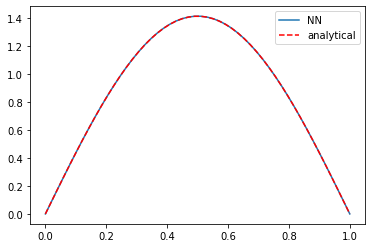

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
x = np.linspace(x0, x1)[:, None]
y = psi(params['nn'], x)

plt.plot(x, y, label='NN')  # Plotting the NN output
plt.plot(x, np.sqrt(2/L) * np.sin(n*np.pi * (x-x0)/L), 'r--', label='analytical')  # Plotting the actual wavefuncion
plt.legend()
plt.savefig (name + "_plot.png")

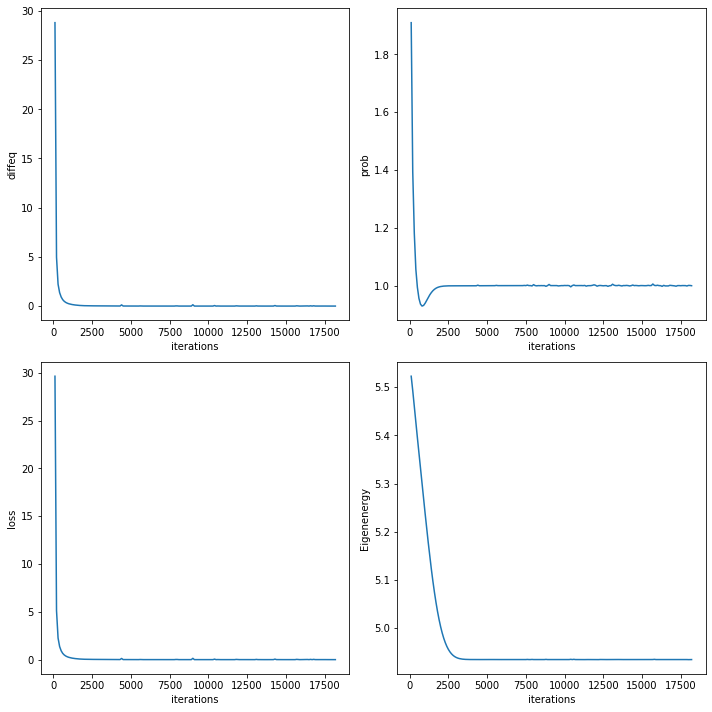

In [9]:
fig = plt.figure (figsize=(10,10))
plt.clf ()

plt.subplot (2 , 2 , 1)
plt.plot (iterList, diffeqList)
plt.xlabel ('iterations')
plt.ylabel ('diffeq')

plt.subplot (2, 2, 2)
plt.plot (iterList, probList)
plt.xlabel ('iterations')
plt.ylabel ('prob')

plt.subplot (2, 2, 3)
plt.plot (iterList, lossList)
plt.xlabel ('iterations')
plt.ylabel ('loss')

plt.subplot (2, 2, 4)
plt.plot (iterList, EList)
plt.ylabel ('Eigenenergy')
plt.xlabel ('iterations')
plt.tight_layout()

plt.savefig (name + "_diagAll.png")

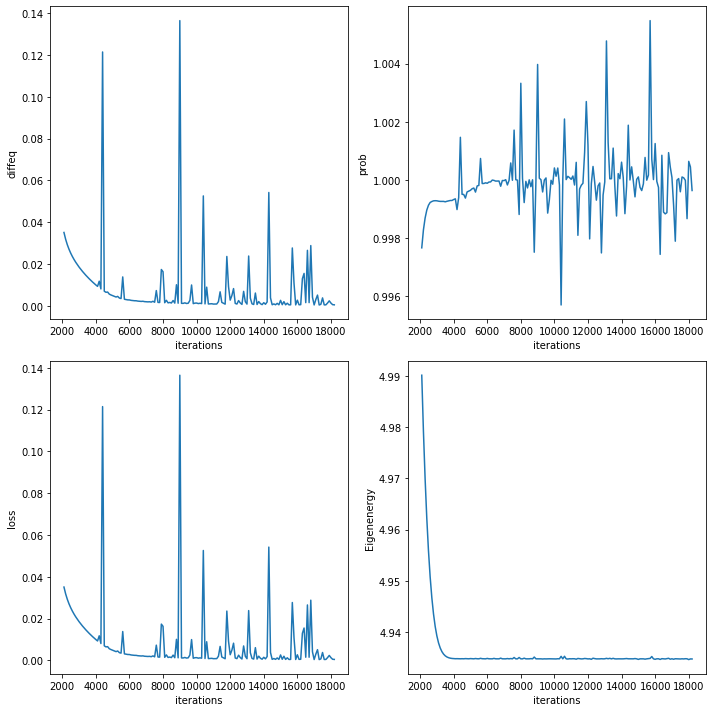

In [10]:
if trunc != -1 :
    fig = plt.figure (figsize=(10,10))

    plt.subplot (2 , 2 , 1)
    plt.plot (iterList[trunc:], diffeqList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeq')

    plt.subplot (2, 2, 2)
    plt.plot (iterList[trunc:], probList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('prob')

    plt.subplot (2, 2, 3)
    plt.plot (iterList[trunc:], lossList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('loss')

    plt.subplot (2, 2, 4)
    plt.plot (iterList[trunc:], EList[trunc:])
    plt.ylabel ('Eigenenergy')
    plt.xlabel ('iterations')
    plt.tight_layout()

    plt.savefig (name + "_diagTrunc" + str(trunc) + ".png")

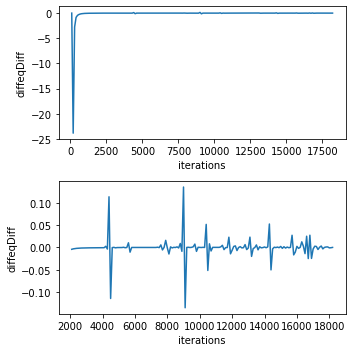

In [11]:
fig = plt.figure (figsize=(5,5))
plt.clf ()

if trunc != -1 :
    plt.subplot (2 , 1 , 1)
    plt.plot (iterList, diffeqDiffList)
    plt.xlabel ('iterations')
    plt.ylabel ('diffeqDiff')

    plt.subplot (2 , 1 , 2)
    plt.plot (iterList[trunc:], diffeqDiffList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeqDiff')
else :
    plt.plot (iterList, diffeqDiffList)
    #plt.yticks ([min(diffeqDiffList), -10**-4, 10**-4, max(diffeqDiffList)])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeqDiff')

plt.tight_layout()
plt.savefig (name + "_diffeqDiff.png")

# Write to file

In [12]:
outfile = open(name + "_info.txt" , "w")

fstr = "diffeq = " + str(round(diffeqList[-1],8)) + \
"\nprob = " + str(round(probList[-1],8)) + \
"\nloss = " + str(round(lossList[-1],8)) + \
"\neigE = " + str(round(EList[-1],8)) + \
"\ndiffeqDiff = " + str(round(diffeqDiffList[-1],8))

    
outfile.write (fstr)
outfile.close ()